In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import ariel_simple
import tqdm

local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 862 ms, sys: 207 ms, total: 1.07 s
Wall time: 3.25 s


(1100, 1)

In [3]:
def robust_linear_fit_rms(X, Y, drop_frac=0.05, do_print=False):
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Fit Y = aX + b using least squares
    A = np.vstack([X, np.ones_like(X)]).T
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Predicted Y and residuals
    Y_pred = a * X + b
    residuals = Y - Y_pred
    abs_resid = np.abs(residuals)

    # Remove worst 5% (highest absolute residuals)
    if drop_frac>0:
        n = len(residuals)
        keep = int(n * (1 - drop_frac))
        indices = np.argpartition(abs_resid, keep)[:keep]
    #print(keep, len(residuals))
    else:
        indices = np.arange(len(residuals))

    # Compute RMS of the remaining residuals
    rms = np.sqrt(np.mean(residuals[indices] ** 2))
    if do_print:
        print(a,b)
    return rms,residuals

In [4]:
df = 0.05
kgs.sanity_checks_without_errors = True
for jj in range(14):
    model = ariel_simple.SimpleModel()
    model.run_in_parallel = (jj<6)
    match jj:
        case 0:
            name = 'Default'
        case 1:
            name = 'Supersample'
            model.supersample_factor = 5
        case 2:
            name = 'Fit eccentricity'
            model.fit_ecc = True
        case 3:
            name = 'Correction factor'
            model.use_correction_factor = True
        case 4:
            name = '4th order'
            model.order_list = [0,1,2,3,4]
        case 5:
            name = '6th order'
            model.order_list = [0,1,2,3,4,5,6]
        case 6:
            name = 'Use more AIRS rows'
            model.loaders[1].apply_full_sensor_corrections.remove_background_n_rows = 4            
        case 7:
            name = 'Don''t mask dead'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.mask_dead = False
            model.run_in_parallel = False
        case 8:
            name = 'Don''t mask hot'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.mask_hot = False
            model.run_in_parallel = False
        case 9:
            name = 'No linear correction'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.linear_correction = False
        case 10:
            name = 'Dark current sign'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.dark_current_sign *= -1
        case 11:
            name = 'ADC sign'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.adc_offset_sign *= -1
        case 12:
            name = 'No flat field'
            for ii in range(2):
                model.loaders[ii].apply_pixel_corrections.flat_field = False
        case 13:
            name = 'Time binning x2'
            for ii in range(2):
                model.loaders[ii].apply_time_binning.time_binning*=2                
    model.train(train_data)
    data = train_data[:200]
    inferred_data = model.infer(data)
    print(name)
    solution = kgs.make_submission_dataframe(data, include_sigma=False)
    submission = kgs.make_submission_dataframe(inferred_data, False)
    print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df)[0], 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0)[0])
    print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df)[0],
         1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0)[0])
    kgs.sanity_checks['simple_residual_diff_FGS'] = kgs.SanityCheckValue('simple_residual_diff_FGS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_FGS'].seen_all = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
    kgs.sanity_checks['simple_residual_diff_AIRS'] = kgs.SanityCheckValue('simple_residual_diff_AIRS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
    kgs.dill_save(kgs.temp_dir + '/compare_simple'+str(jj)+'.pickle', (data,inferred_data,kgs.sanity_checks,name))

Processing in parallel:   0%|                                                                   | 0/200 [00:00<?, ?it/s]

local
local
local
local
local
local
local


Processing in parallel: 100%|█████████████████████████████████████████████████████████| 200/200 [01:49<00:00,  1.83it/s]


Default
170.89910488638435 296.7023639767347
77.42342283955908 152.7639875347138


Processing in parallel:   0%|                                                                   | 0/200 [00:00<?, ?it/s]

local
local
local
locallocal

local
local


Processing in parallel: 100%|█████████████████████████████████████████████████████████| 200/200 [04:29<00:00,  1.35s/it]


Supersample
176.54765374899313 311.70276167304166
69.21318169967356 138.3515292592418


Processing in parallel:   0%|                                                                   | 0/200 [00:00<?, ?it/s]

local
local
local
local
local
local
local


Processing in parallel: 100%|█████████████████████████████████████████████████████████| 200/200 [01:29<00:00,  2.24it/s]


Fit eccentricity
173.71085284927565 334.97947267059675
68.77500315174704 210.05762648839186


Processing in parallel:   0%|                                                                   | 0/200 [00:00<?, ?it/s]

local
local
local
local
local
local
local


Processing in parallel: 100%|█████████████████████████████████████████████████████████| 200/200 [01:18<00:00,  2.53it/s]


Correction factor
217.5545337935301 335.4804843650691
74.00988570789184 161.5552372630509


Processing in parallel:   0%|                                                                   | 0/200 [00:00<?, ?it/s]

local
local
local
local
local
local
local


Processing in parallel: 100%|█████████████████████████████████████████████████████████| 200/200 [01:05<00:00,  3.04it/s]


4th order
143.71534906870863 263.76749898679003
65.53319037013713 144.65209304562464


Processing in parallel:   0%|                                                                   | 0/200 [00:00<?, ?it/s]

local
local
locallocal

local
local
local


Processing in parallel: 100%|█████████████████████████████████████████████████████████| 200/200 [01:15<00:00,  2.63it/s]


6th order
195.97578448700997 323.76264118351224
93.34022449790623 170.131552618902


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [05:42<00:00,  1.71s/it]


Use more AIRS rows
175.88941436921144 307.1407424898683
71.25314588720596 142.6129444539545


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [11:50<00:00,  3.55s/it]


Dont mask dead
35319.0786776864 74185.11380349129
918.33631428899 1798.9231903644443


Inferring:   5%|███▌                                                                   | 10/200 [00:17<05:24,  1.71s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|███▉                                                                   | 11/200 [00:21<06:07,  1.94s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▎                                                                  | 12/200 [00:23<06:25,  2.05s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   6%|████▌                                                                  | 13/200 [00:26<06:33,  2.11s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   7%|████▉                                                                  | 14/200 [00:29<06:47,  2.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▎                                                                 | 15/200 [00:32<06:57,  2.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|█████▋                                                                 | 16/200 [00:35<07:11,  2.35s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   8%|██████                                                                 | 17/200 [00:40<07:49,  2.56s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:   9%|██████▍                                                                | 18/200 [00:43<07:53,  2.60s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|██████▋                                                                | 19/200 [00:46<07:54,  2.62s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|███████                                                                | 20/200 [00:49<07:56,  2.65s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  10%|███████▍                                                               | 21/200 [00:52<07:58,  2.67s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  11%|███████▊                                                               | 22/200 [00:55<07:55,  2.67s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▏                                                              | 23/200 [00:58<07:57,  2.70s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▌                                                              | 24/200 [01:00<07:54,  2.70s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  12%|████████▉                                                              | 25/200 [01:03<07:49,  2.68s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  13%|█████████▏                                                             | 26/200 [01:06<07:52,  2.71s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▌                                                             | 27/200 [01:09<07:53,  2.73s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|█████████▉                                                             | 28/200 [01:14<08:14,  2.87s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  14%|██████████▎                                                            | 29/200 [01:17<08:12,  2.88s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  15%|██████████▋                                                            | 30/200 [01:21<08:21,  2.95s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████                                                            | 31/200 [01:24<08:17,  2.95s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████▎                                                           | 32/200 [01:26<08:11,  2.93s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  16%|███████████▋                                                           | 33/200 [01:29<08:09,  2.93s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  17%|████████████                                                           | 34/200 [01:32<08:07,  2.94s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▍                                                          | 35/200 [01:35<08:05,  2.94s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|████████████▊                                                          | 36/200 [01:38<08:01,  2.94s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  18%|█████████████▏                                                         | 37/200 [01:41<08:00,  2.95s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  19%|█████████████▍                                                         | 38/200 [01:44<07:56,  2.94s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|█████████████▊                                                         | 39/200 [01:49<08:09,  3.04s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|██████████████▏                                                        | 40/200 [01:52<08:07,  3.05s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  20%|██████████████▌                                                        | 41/200 [01:55<08:03,  3.04s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  21%|██████████████▉                                                        | 42/200 [01:58<07:59,  3.04s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▎                                                       | 43/200 [02:02<08:05,  3.09s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▌                                                       | 44/200 [02:05<08:03,  3.10s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  22%|███████████████▉                                                       | 45/200 [02:08<08:00,  3.10s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  23%|████████████████▎                                                      | 46/200 [02:11<07:57,  3.10s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|████████████████▋                                                      | 47/200 [02:15<07:57,  3.12s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|█████████████████                                                      | 48/200 [02:18<07:55,  3.13s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  24%|█████████████████▍                                                     | 49/200 [02:22<08:03,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  25%|█████████████████▊                                                     | 50/200 [02:26<08:01,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████                                                     | 51/200 [02:29<07:56,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████▍                                                    | 52/200 [02:32<07:52,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  26%|██████████████████▊                                                    | 53/200 [02:35<07:45,  3.17s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  27%|███████████████████▏                                                   | 54/200 [02:38<07:43,  3.17s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▌                                                   | 55/200 [02:41<07:35,  3.14s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|███████████████████▉                                                   | 56/200 [02:43<07:28,  3.11s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  28%|████████████████████▏                                                  | 57/200 [02:46<07:25,  3.12s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  29%|████████████████████▌                                                  | 58/200 [02:49<07:20,  3.11s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|████████████████████▉                                                  | 59/200 [02:53<07:19,  3.12s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|█████████████████████▎                                                 | 60/200 [02:58<07:30,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  30%|█████████████████████▋                                                 | 61/200 [03:00<07:24,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  31%|██████████████████████                                                 | 62/200 [03:03<07:19,  3.18s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████▎                                                | 63/200 [03:06<07:13,  3.16s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|██████████████████████▋                                                | 64/200 [03:09<07:09,  3.16s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  32%|███████████████████████                                                | 65/200 [03:12<07:03,  3.14s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  33%|███████████████████████▍                                               | 66/200 [03:15<06:57,  3.12s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|███████████████████████▊                                               | 67/200 [03:18<06:53,  3.11s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|████████████████████████▏                                              | 68/200 [03:21<06:50,  3.11s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  34%|████████████████████████▍                                              | 69/200 [03:25<06:52,  3.15s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  35%|████████████████████████▊                                              | 70/200 [03:29<06:59,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|█████████████████████████▏                                             | 71/200 [03:32<06:54,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|█████████████████████████▌                                             | 72/200 [03:36<06:53,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  36%|█████████████████████████▉                                             | 73/200 [03:39<06:48,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  37%|██████████████████████████▎                                            | 74/200 [03:42<06:42,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▋                                            | 75/200 [03:44<06:36,  3.17s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|██████████████████████████▉                                            | 76/200 [03:47<06:32,  3.16s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  38%|███████████████████████████▎                                           | 77/200 [03:51<06:31,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  39%|███████████████████████████▋                                           | 78/200 [03:53<06:24,  3.15s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|████████████████████████████                                           | 79/200 [03:57<06:21,  3.15s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|████████████████████████████▍                                          | 80/200 [04:00<06:18,  3.15s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  40%|████████████████████████████▊                                          | 81/200 [04:04<06:23,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  41%|█████████████████████████████                                          | 82/200 [04:07<06:20,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|█████████████████████████████▍                                         | 83/200 [04:10<06:14,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|█████████████████████████████▊                                         | 84/200 [04:13<06:09,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  42%|██████████████████████████████▏                                        | 85/200 [04:16<06:05,  3.18s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  43%|██████████████████████████████▌                                        | 86/200 [04:19<06:02,  3.18s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|██████████████████████████████▉                                        | 87/200 [04:23<05:58,  3.17s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|███████████████████████████████▏                                       | 88/200 [04:26<05:54,  3.17s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  44%|███████████████████████████████▌                                       | 89/200 [04:29<05:50,  3.16s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  45%|███████████████████████████████▉                                       | 90/200 [04:32<05:48,  3.17s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|████████████████████████████████▎                                      | 91/200 [04:37<05:55,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|████████████████████████████████▋                                      | 92/200 [04:40<05:52,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  46%|█████████████████████████████████                                      | 93/200 [04:43<05:46,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  47%|█████████████████████████████████▎                                     | 94/200 [04:46<05:41,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|█████████████████████████████████▋                                     | 95/200 [04:49<05:37,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|██████████████████████████████████                                     | 96/200 [04:52<05:35,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  48%|██████████████████████████████████▍                                    | 97/200 [04:55<05:30,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  49%|██████████████████████████████████▊                                    | 98/200 [04:58<05:24,  3.18s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|███████████████████████████████████▏                                   | 99/200 [05:01<05:19,  3.16s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|███████████████████████████████████                                   | 100/200 [05:03<05:13,  3.14s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  50%|███████████████████████████████████▎                                  | 101/200 [05:07<05:13,  3.16s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  51%|███████████████████████████████████▋                                  | 102/200 [05:12<05:19,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|████████████████████████████████████                                  | 103/200 [05:15<05:14,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|████████████████████████████████████▍                                 | 104/200 [05:18<05:10,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  52%|████████████████████████████████████▊                                 | 105/200 [05:22<05:09,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  53%|█████████████████████████████████████                                 | 106/200 [05:25<05:04,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▍                                | 107/200 [05:28<05:01,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  54%|█████████████████████████████████████▊                                | 108/200 [05:31<04:56,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|██████████████████████████████████████▏                               | 109/200 [05:34<04:51,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  55%|██████████████████████████████████████▌                               | 110/200 [05:37<04:47,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|██████████████████████████████████████▊                               | 111/200 [05:40<04:42,  3.18s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|███████████████████████████████████████▏                              | 112/200 [05:44<04:47,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  56%|███████████████████████████████████████▌                              | 113/200 [05:48<04:43,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|███████████████████████████████████████▉                              | 114/200 [05:51<04:40,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  57%|████████████████████████████████████████▎                             | 115/200 [05:54<04:37,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████▌                             | 116/200 [05:57<04:33,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  58%|████████████████████████████████████████▉                             | 117/200 [06:00<04:28,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  59%|█████████████████████████████████████████▎                            | 118/200 [06:04<04:25,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|█████████████████████████████████████████▋                            | 119/200 [06:06<04:20,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|██████████████████████████████████████████                            | 120/200 [06:09<04:16,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  60%|██████████████████████████████████████████▎                           | 121/200 [06:13<04:13,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  61%|██████████████████████████████████████████▋                           | 122/200 [06:16<04:09,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|███████████████████████████████████████████                           | 123/200 [06:20<04:11,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|███████████████████████████████████████████▍                          | 124/200 [06:23<04:07,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  62%|███████████████████████████████████████████▊                          | 125/200 [06:26<04:03,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  63%|████████████████████████████████████████████                          | 126/200 [06:29<03:58,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▍                         | 127/200 [06:32<03:53,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|████████████████████████████████████████████▊                         | 128/200 [06:35<03:50,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  64%|█████████████████████████████████████████████▏                        | 129/200 [06:38<03:47,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  65%|█████████████████████████████████████████████▌                        | 130/200 [06:42<03:45,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|█████████████████████████████████████████████▊                        | 131/200 [06:45<03:41,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|██████████████████████████████████████████████▏                       | 132/200 [06:48<03:37,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  66%|██████████████████████████████████████████████▌                       | 133/200 [06:53<03:41,  3.30s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  67%|██████████████████████████████████████████████▉                       | 134/200 [06:56<03:35,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|███████████████████████████████████████████████▎                      | 135/200 [06:59<03:30,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|███████████████████████████████████████████████▌                      | 136/200 [07:01<03:26,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  68%|███████████████████████████████████████████████▉                      | 137/200 [07:04<03:21,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  69%|████████████████████████████████████████████████▎                     | 138/200 [07:07<03:18,  3.20s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|████████████████████████████████████████████████▋                     | 139/200 [07:12<03:19,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|█████████████████████████████████████████████████                     | 140/200 [07:15<03:16,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  70%|█████████████████████████████████████████████████▎                    | 141/200 [07:19<03:13,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  71%|█████████████████████████████████████████████████▋                    | 142/200 [07:21<03:08,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|██████████████████████████████████████████████████                    | 143/200 [07:26<03:09,  3.32s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|██████████████████████████████████████████████████▍                   | 144/200 [07:29<03:04,  3.30s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  72%|██████████████████████████████████████████████████▊                   | 145/200 [07:32<03:00,  3.28s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  73%|███████████████████████████████████████████████████                   | 146/200 [07:35<02:55,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████▍                  | 147/200 [07:38<02:51,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|███████████████████████████████████████████████████▊                  | 148/200 [07:41<02:48,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  74%|████████████████████████████████████████████████████▏                 | 149/200 [07:44<02:45,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  75%|████████████████████████████████████████████████████▌                 | 150/200 [07:47<02:42,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|████████████████████████████████████████████████████▊                 | 151/200 [07:50<02:38,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|█████████████████████████████████████████████████████▏                | 152/200 [07:53<02:34,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  76%|█████████████████████████████████████████████████████▌                | 153/200 [07:57<02:31,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  77%|█████████████████████████████████████████████████████▉                | 154/200 [08:02<02:33,  3.33s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|██████████████████████████████████████████████████████▎               | 155/200 [08:05<02:28,  3.30s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|██████████████████████████████████████████████████████▌               | 156/200 [08:08<02:24,  3.29s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  78%|██████████████████████████████████████████████████████▉               | 157/200 [08:11<02:20,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  79%|███████████████████████████████████████████████████████▎              | 158/200 [08:14<02:16,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|███████████████████████████████████████████████████████▋              | 159/200 [08:17<02:12,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|████████████████████████████████████████████████████████              | 160/200 [08:20<02:09,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  80%|████████████████████████████████████████████████████████▎             | 161/200 [08:23<02:05,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  81%|████████████████████████████████████████████████████████▋             | 162/200 [08:26<02:02,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|█████████████████████████████████████████████████████████             | 163/200 [08:29<01:58,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|█████████████████████████████████████████████████████████▍            | 164/200 [08:34<01:58,  3.30s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  82%|█████████████████████████████████████████████████████████▊            | 165/200 [08:37<01:55,  3.30s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  83%|██████████████████████████████████████████████████████████            | 166/200 [08:40<01:51,  3.28s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|██████████████████████████████████████████████████████████▍           | 167/200 [08:43<01:47,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|██████████████████████████████████████████████████████████▊           | 168/200 [08:46<01:44,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  84%|███████████████████████████████████████████████████████████▏          | 169/200 [08:50<01:41,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  85%|███████████████████████████████████████████████████████████▌          | 170/200 [08:53<01:38,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|███████████████████████████████████████████████████████████▊          | 171/200 [08:56<01:34,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|████████████████████████████████████████████████████████████▏         | 172/200 [08:59<01:30,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  86%|████████████████████████████████████████████████████████████▌         | 173/200 [09:02<01:27,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  87%|████████████████████████████████████████████████████████████▉         | 174/200 [09:05<01:23,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|█████████████████████████████████████████████████████████████▎        | 175/200 [09:09<01:21,  3.28s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|█████████████████████████████████████████████████████████████▌        | 176/200 [09:13<01:18,  3.27s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  88%|█████████████████████████████████████████████████████████████▉        | 177/200 [09:15<01:14,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  89%|██████████████████████████████████████████████████████████████▎       | 178/200 [09:18<01:10,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|██████████████████████████████████████████████████████████████▋       | 179/200 [09:21<01:07,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|███████████████████████████████████████████████████████████████       | 180/200 [09:25<01:04,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  90%|███████████████████████████████████████████████████████████████▎      | 181/200 [09:28<01:01,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  91%|███████████████████████████████████████████████████████████████▋      | 182/200 [09:31<00:58,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|████████████████████████████████████████████████████████████████      | 183/200 [09:34<00:54,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|████████████████████████████████████████████████████████████████▍     | 184/200 [09:37<00:51,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  92%|████████████████████████████████████████████████████████████████▊     | 185/200 [09:41<00:48,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  93%|█████████████████████████████████████████████████████████████████     | 186/200 [09:45<00:46,  3.30s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|█████████████████████████████████████████████████████████████████▍    | 187/200 [09:48<00:42,  3.28s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|█████████████████████████████████████████████████████████████████▊    | 188/200 [09:51<00:39,  3.26s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  94%|██████████████████████████████████████████████████████████████████▏   | 189/200 [09:54<00:35,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  95%|██████████████████████████████████████████████████████████████████▌   | 190/200 [09:57<00:32,  3.22s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|██████████████████████████████████████████████████████████████████▊   | 191/200 [10:00<00:28,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|███████████████████████████████████████████████████████████████████▏  | 192/200 [10:03<00:25,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  96%|███████████████████████████████████████████████████████████████████▌  | 193/200 [10:06<00:22,  3.19s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  97%|███████████████████████████████████████████████████████████████████▉  | 194/200 [10:09<00:19,  3.18s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|████████████████████████████████████████████████████████████████████▎ | 195/200 [10:12<00:15,  3.17s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|████████████████████████████████████████████████████████████████████▌ | 196/200 [10:17<00:12,  3.25s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  98%|████████████████████████████████████████████████████████████████████▉ | 197/200 [10:20<00:09,  3.23s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring:  99%|█████████████████████████████████████████████████████████████████████▎| 198/200 [10:22<00:06,  3.21s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|█████████████████████████████████████████████████████████████████████▋| 199/200 [10:26<00:03,  3.24s/it]

deal with extremely negative dark in test set first...also more sanity checks may fail
deal with extremely negative dark in test set first...also more sanity checks may fail


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [10:29<00:00,  3.15s/it]


Dont mask hot
177.88741397134282 300.0375904391455
65.47775314890761 146.3646150336926


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [10:09<00:00,  3.05s/it]


No linear correction
218.15133347007352 339.2836192232187
82.65913396850013 156.45713936679638


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [10:33<00:00,  3.17s/it]


Dark current sign
170.8135736597774 299.77989176191886
70.75532909662127 147.8133817800193


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [10:29<00:00,  3.15s/it]


ADC sign
182.32881481288698 321.36748158070947
73.93983052859359 142.33660267216135


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [10:29<00:00,  3.15s/it]


No flat field
178.49554051422155 314.63606427593567
73.77552379646175 144.95525035836897


Inferring: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [09:08<00:00,  2.74s/it]


Time binning x2
178.61697636024087 306.4721500242966
73.9216068004526 145.87503281844525


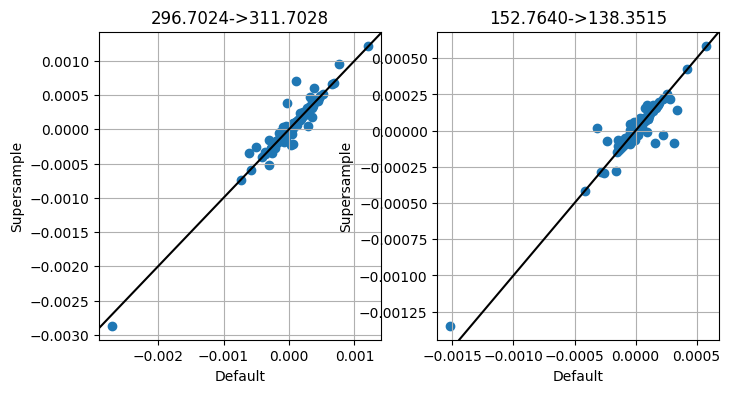

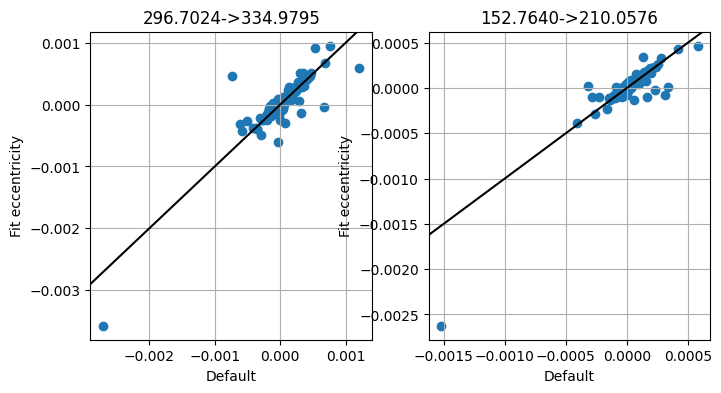

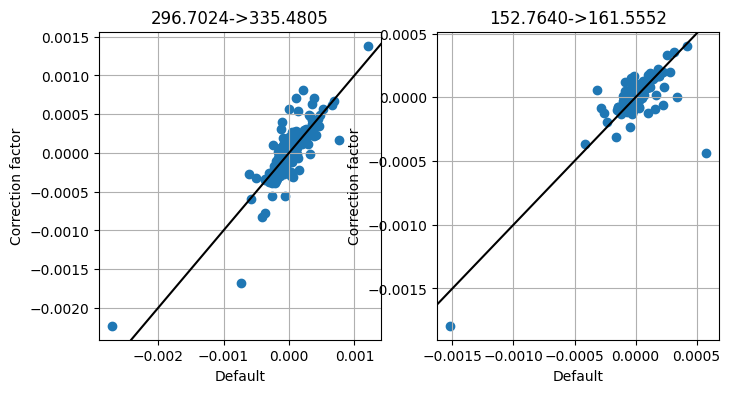

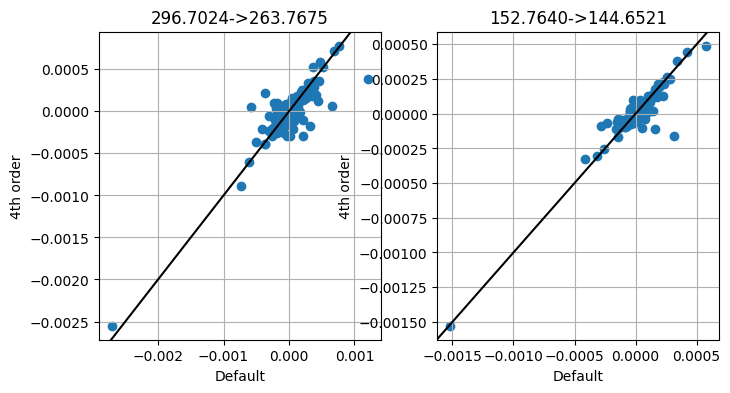

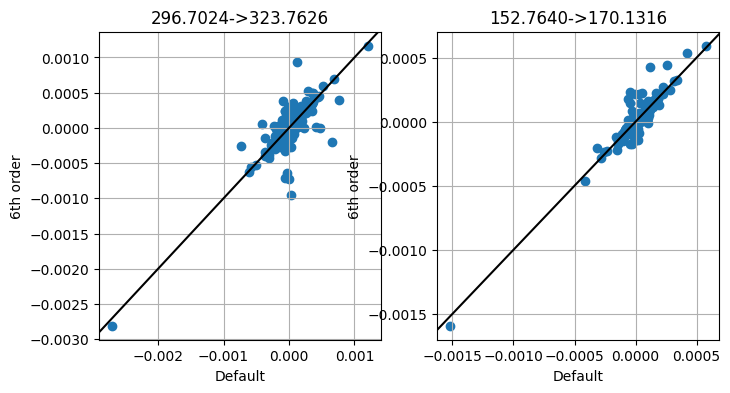

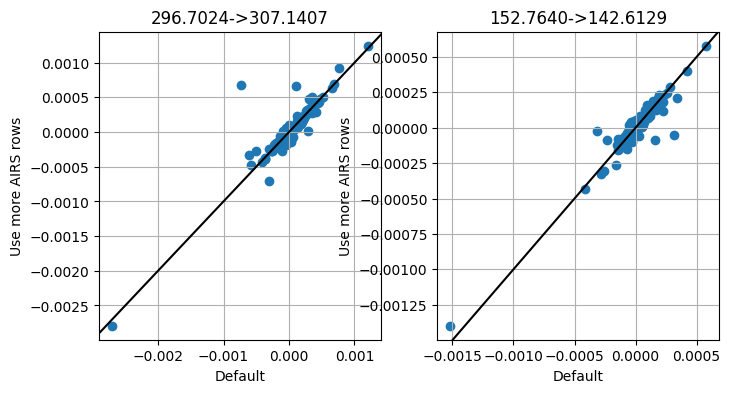

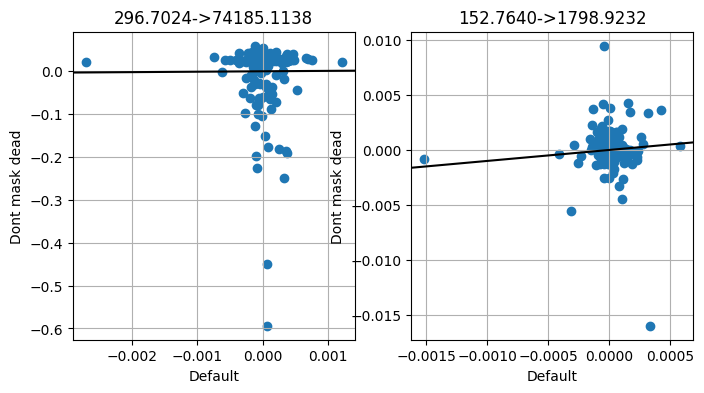

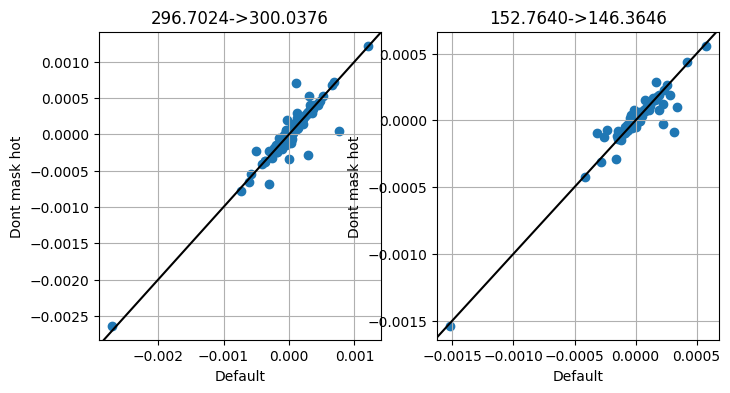

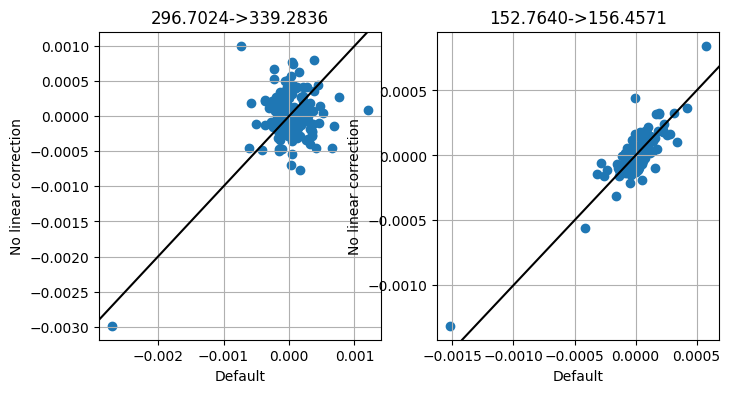

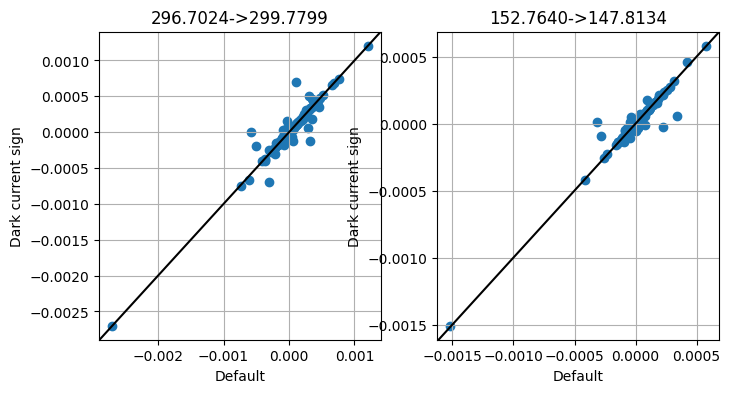

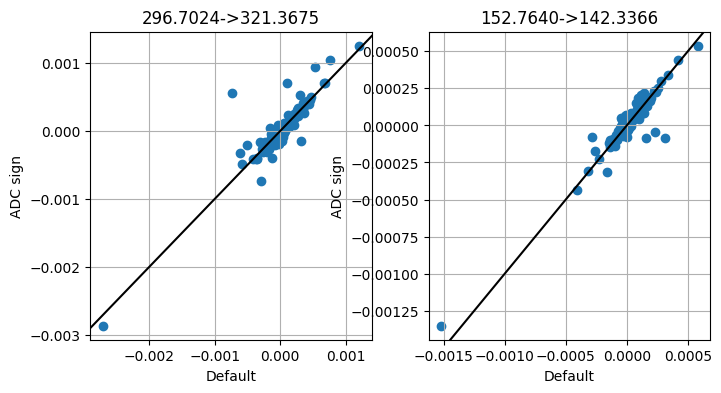

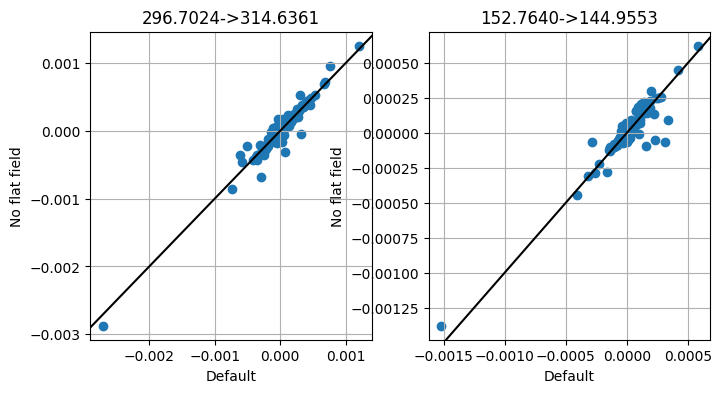

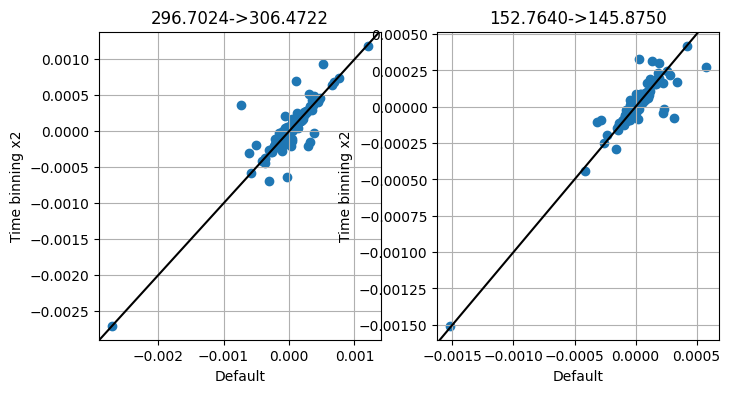

In [10]:
def process_solution(dat):
    solution = kgs.make_submission_dataframe(dat[0], include_sigma=False)
    submission = kgs.make_submission_dataframe(dat[1], False)
    fgs_err = robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), do_print=False)[1]
    airs_err = robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1), do_print=False)[1]
    return fgs_err,airs_err,dat[3]
dat_base = process_solution(kgs.dill_load(kgs.temp_dir + '/compare_simple'+str(0)+'.pickle'))
for jj in range(1,14):
    dat_this = process_solution(kgs.dill_load(kgs.temp_dir + '/compare_simple'+str(jj)+'.pickle'))
    _,ax = plt.subplots(1,2,figsize=(8,4))
    for ii in range(2):
        plt.sca(ax[ii])
        plt.grid(True)
        plt.scatter(dat_base[ii], dat_this[ii])
        plt.axline((0,0), slope=1, color='black')
        plt.title(f'{1e6*kgs.rms(dat_base[ii]):.4f}->{1e6*kgs.rms(dat_this[ii]):.4f}')
        plt.xlabel(dat_base[2])
        plt.ylabel(dat_this[2])